# Import des outils / jeu de données

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [ ]:
np.random.seed(0)
sns.set_theme()

In [ ]:
df = pd.read_csv(
    "data/data-cleaned-feature-engineering.csv",
    sep=",",
    index_col="ID",
    parse_dates=True,
)

In [ ]:
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,NbAcceptedCampaigns,HasAcceptedCampaigns,NbChildren
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,...,0,0,0,0,0,0,1,0,False,0
2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,...,0,0,0,0,0,0,0,0,False,2
4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,...,0,0,0,0,0,0,0,0,False,0
6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,...,0,0,0,0,0,0,0,0,False,1
5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,...,0,0,0,0,0,0,0,0,False,1


# Tests d'hypothèse

## ANOVA

### Problématique

Nous allons tester l'indépendance entre la variable `Response` (catégorique, binaire) et `Income` (quantitative continue), pour répondre à la question : "le revenu influence-t-il la réponse aux campagnes marketing ?".

<Axes: xlabel='Income', ylabel='Response'>

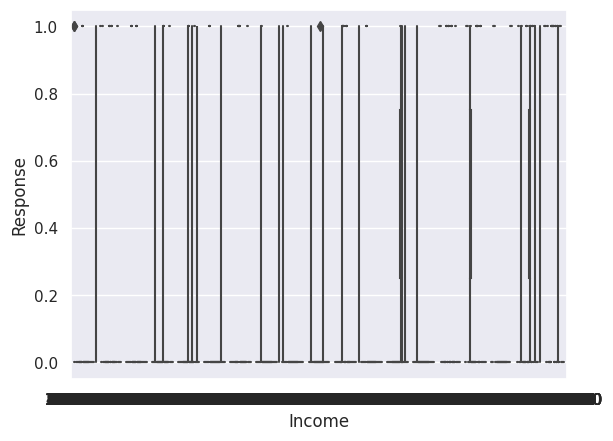

<Axes: xlabel='Income', ylabel='Response'>

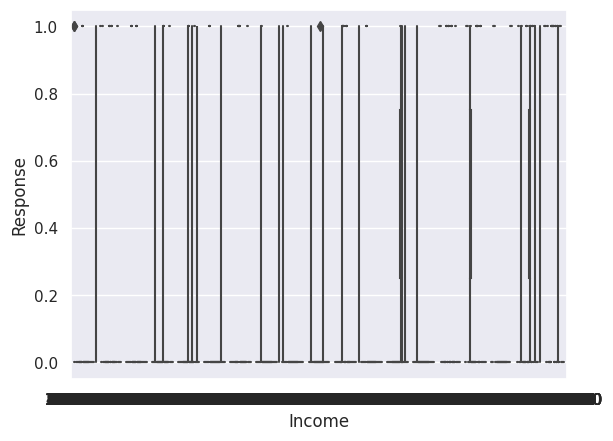

In [ ]:
sns.boxplot(df, x="Income", y="Response")

On cherche à déterminer si les moyennes des groupes sont significativement différentes. On pose donc :

$H_0$ : Les moyennes de chaque groupe sont égales si la p-value $> 5\%$
$H_1$ : Les moyennes de chaque groupe ne sont pas toutes égales si la p-value $< 5\%$


### Hypothèses

1) l’indépendance entre les échantillons de chaque groupe
2) l’égalité des variances que l’on peut verifier avec un test de Bartlett.
3) la normalité des résidus avec un test de Shapiro.

#### Indépendance

#### Egalité des variances

In [ ]:
from scipy.stats import bartlett

Voici la variance de chaque groupe :

In [ ]:
df.groupby("Response")["Income"].agg("var")

Response
0    3.895393e+08
1    5.353886e+08
Name: Income, dtype: float64

Nous allons effectuer un test de Bartlett pour vérifier l'égalité des variances.

$H_0$ : Les variances de chaque groupe sont égales si p-value $> 5\%$
$H_1$ : Les variances de chaque groupe ne sont pas toutes égales $< 5\%$


In [ ]:
bartlett(
    df["Income"][df["Response"] == "0"],
    df["Income"][df["Response"] == "1"],
)

BartlettResult(statistic=nan, pvalue=nan)

Notre p-value est inférieure à 5%, donc les variances ne sont pas toutes égales au (risque de 5%).

#### Normalité des résidus

Nous utilisons le test de Shapiro-Wilk pour vérifier la normalité des résidus.

H0 : Les résidus suivent une loi normale si p-value > 5%
H1 : Les résidus ne suivent pas une loi normale si p-value < 5%

In [ ]:
from scipy.stats import shapiro
from statsmodels.formula.api import ols

model = ols("Income ~ Response", data=df).fit()
shapiro(model.resid)

ShapiroResult(statistic=0.9858090281486511, pvalue=2.2619989106624494e-13)

Comme la p-value est inférieure à 5%, les résidus ne suivent pas une loi normale (au risque de 5%).

#### Test d'ANOVA

H0 : Les moyennes de chaque groupe sont égales si p-value > 5%
H1 : Les moyennes de chaque groupe ne sont pas toutes égales < 5%

In [ ]:
import statsmodels.api as sm

anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

,sum_sq,df,F,PR(>F)
Response,2.603158e+10,1.0,63.234078,3.009743e-15
Residual,8.410420e+11,2043.0,NaN,NaN


Comme aucune hypothèse n'est vérifiée, le test n'est pas fiable.

In [ ]:
# todo: tenter le GLS